# Model - Multivariate Multi-step LSTM Models

## All Changes

In [1]:
name_of_data = 'Stock_Data.csv'

## LIbs

In [2]:
# all packages
import numpy as np
import pandas as pd
from numpy import array
from numpy import hstack
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
import matplotlib.pyplot as plt
%matplotlib inline

## Load Data as *.csv

<TICKER>      object
<FIRST>        int64
<HIGH>         int64
<LOW>          int64
<CLOSE>        int64
<VALUE>      float64
<VOL>          int64
<OPENINT>      int64
<PER>         object
<OPEN>         int64
<LAST>         int64
dtype: object


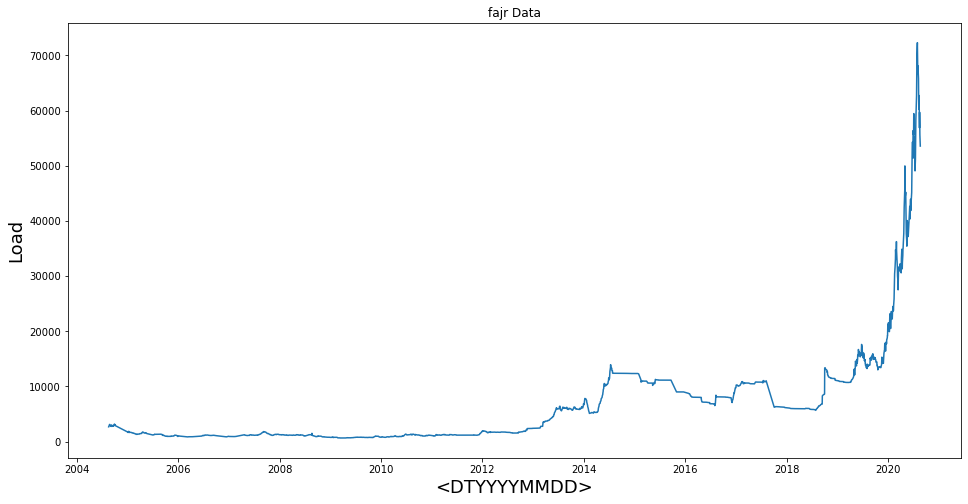

                     <TICKER>  <FIRST>  <HIGH>  <LOW>  <CLOSE>       <VALUE>  \
<DTYYYYMMDD>                                                                   
2004-08-16    Amirkabir.Steel     2732    2732   2601     2678  4.426716e+09   
2004-08-18    Amirkabir.Steel     2811    2811   2811     2811  1.172187e+09   
2004-08-21    Amirkabir.Steel     2951    2951   2951     2951  5.016700e+09   
2004-08-22    Amirkabir.Steel     3098    3098   3000     3097  2.461034e+10   
2004-08-23    Amirkabir.Steel     3097    3250   3070     3101  6.107483e+09   
...                       ...      ...     ...    ...      ...           ...   
2020-08-16    Amirkabir.Steel    56770   59600  56700    56860  1.770000e+11   
2020-08-17    Amirkabir.Steel    59700   59700  58160    59690  5.010000e+11   
2020-08-18    Amirkabir.Steel    61000   61000  56710    57340  1.600000e+11   
2020-08-19    Amirkabir.Steel    54480   54480  54480    55620  2.611079e+10   
2020-08-22    Amirkabir.Steel    57640  

In [3]:
# load data + set time
data = pd.read_csv(name_of_data, index_col='<DTYYYYMMDD>', parse_dates=True)
data= data.sort_values('<DTYYYYMMDD>',ascending=True)
print(data.dtypes)

plt.figure(figsize=(16, 8))
plt.title('fajr Data')
plt.plot(data['<CLOSE>'])
plt.xlabel('<DTYYYYMMDD>', fontsize=18)
plt.ylabel('Load', fontsize=18)
plt.show()

print(data)

In [4]:
# define scaler for Normalize Data
scaler = preprocessing.MinMaxScaler(feature_range = (0, 1))

In [5]:
# define train data
#data_train = data.loc[:"2020-08-12", :]
data_train = data.loc[:, :]

x_train = array(scaler.fit_transform(data_train[['<HIGH>', '<LOW>', '<VALUE>', '<VOL>']]))
y_train = array(scaler.fit_transform(data_train[['<CLOSE>']]))
n_features = 4

In [6]:
# convert to [rows, columns] structure
x_train = x_train.reshape((len(x_train), n_features))
y_train = y_train.reshape((len(y_train), 1))

dataset_train = hstack((x_train, y_train))

In [7]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out-1
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [8]:
# choose a number of time steps / features
n_steps_in, n_steps_out = 60, 7

# convert into input/output
X_train, y_train = split_sequences(dataset_train, n_steps_in, n_steps_out)

# print(X_train.shape, y_train.shape)

In [9]:
# define model
model = Sequential()
model.add(LSTM(256, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(Dropout(0.2))

model.add(LSTM(units = 256, return_sequences = True))
model.add(Dropout(0.1))

model.add(LSTM(128, activation='relu'))
model.add(Dropout(0.1))

model.add((Dense(units = 128, activation='relu')))
model.add(Dense(n_steps_out))

model.compile(optimizer='adam', loss='mse', metrics=['mean_squared_error'])
# fit model
model.fit(X_train, y_train, epochs=100, batch_size = 64, verbose=1)

42/42 [==============================] - 18s 432ms/step - loss: 0.0058 - mean_squared_error: 0.0058


## Prediction for next days

In [10]:
# use last 60 days of data to predict next 7 days
x_input = X_train[len(X_train)-1]
x_input = x_input .reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)
inverse_yhat = scaler.inverse_transform(yhat)

print("Prediction of close price for next 7 days: ", inverse_yhat)

Prediction of close price for next 7 days:  [[56560.58  55343.902 55305.727 56904.26  57828.12  58804.1   57591.03 ]]


## Save trained Model as *.h5

In [11]:
model.save('Model_' + name_of_data[:-4] + '.h5')

## Visulaize MOdel